# Improving Models with Feature Engineering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score

%matplotlib inline

## Preparing credit card dataset

In [2]:
default = pd.read_csv('../data/credit_card_default.csv', index_col="ID")
default.rename(columns=lambda x: x.lower(), inplace=True)
default.rename(columns={'pay_0':'pay_1','default payment next month':'default'}, inplace=True)

default['grad_school'] = (default['education'] == 1).astype(int)
default['university'] = (default['education'] == 2).astype(int)
default['high_school'] = (default['education'] == 3).astype(int)
default.drop('education', axis=1, inplace=True)

default['married_male'] = ((default['sex']==1) & (default['marriage'] == 1)).astype(int)
default['not_married_female'] = ((default['sex']==2) & (default['marriage'] != 1)).astype(int)
default.drop(['sex','marriage'], axis=1, inplace=True)

# For pay_n features if >0 then it means the customer was delayed on that month
pay_features = ['pay_' + str(i) for i in range(1,7)]
for p in pay_features:
    default[p] = (default[p] > 0).astype(int)

In [3]:
default.head()

,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school,married_male,not_married_female
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,1,1,0,0,0,0,3913,3102,...,0,0,0,0,1,0,1,0,0,0
2,120000,26,0,1,0,0,0,1,2682,1725,...,1000,1000,0,2000,1,0,1,0,0,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,1000,5000,0,0,1,0,0,1
4,50000,37,0,0,0,0,0,0,46990,48233,...,1200,1100,1069,1000,0,0,1,0,0,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,10000,9000,689,679,0,0,1,0,1,0


### Feature engineering

In [4]:
# Bill amount minus payment
for i in range(1,7):
    i = str(i)
    new_var_name = 'bill_minus_pay' + i
    default[new_var_name] = default['bill_amt'+i] - default['pay_amt'+i]
    
# Reducing the 6 bill amount features to 1
bill_amt_features = ['bill_amt'+str(i) for i in range(1,7)]
bill_amt_pca = PCA(n_components=1)
default['bill_amt_new_feat'] = bill_amt_pca.fit_transform(default[bill_amt_features])[:,0]
default.drop(bill_amt_features, axis=1, inplace=True)

# Reducing the 5 pay_i features to 2
pay_features = ['pay_'+str(i) for i in range(2,7)]
pay_features_pca = PCA(n_components=2).fit_transform(default[pay_features])
default['new_pay1'] = pay_features_pca[:,0]
default['new_pay2'] = pay_features_pca[:,1]
default.drop(pay_features, axis=1, inplace=True)

In [5]:
money_features = ['limit_bal', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
                  'bill_minus_pay1', 'bill_minus_pay2', 'bill_minus_pay3', 'bill_minus_pay4',
                  'bill_minus_pay5', 'bill_minus_pay6', 'bill_amt_new_feat']

In [6]:
default[money_features].var()

limit_bal            1.683446e+10
pay_amt1             2.743423e+08
pay_amt2             5.308817e+08
pay_amt3             3.100051e+08
pay_amt4             2.454286e+08
pay_amt5             2.334266e+08
pay_amt6             3.160383e+08
bill_minus_pay1      5.354403e+09
bill_minus_pay2      5.265815e+09
bill_minus_pay3      4.801847e+09
bill_minus_pay4      4.121718e+09
bill_minus_pay5      3.666711e+09
bill_minus_pay6      3.618178e+09
bill_amt_new_feat    2.418877e+10
dtype: float64

In [7]:
default[money_features] = default[money_features]/1000

In [8]:
default[money_features].var()

limit_bal            16834.455682
pay_amt1               274.342256
pay_amt2               530.881709
pay_amt3               310.005092
pay_amt4               245.428561
pay_amt5               233.426624
pay_amt6               316.038289
bill_minus_pay1       5354.403462
bill_minus_pay2       5265.815238
bill_minus_pay3       4801.847004
bill_minus_pay4       4121.718431
bill_minus_pay5       3666.710625
bill_minus_pay6       3618.177789
bill_amt_new_feat    24188.771200
dtype: float64

## Objects for modelling

In [9]:
target_name = 'default'
X = default.drop('default', axis=1)
feature_names = X.columns
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=125, stratify=y)

## Training new model

In [10]:
parameter_grid = {'n_estimators': [25,50,100], 
                  'max_depth': [15,20,30],
                  'max_features': ['auto','sqrt']}

RF_classifier = GridSearchCV(RandomForestClassifier(random_state=12),
                             param_grid=parameter_grid, refit=True,
                             scoring='recall', cv=10, n_jobs=-1)

RF_classifier.fit(X_train, y_train)
y_pred_test = RF_classifier.predict(X_test)
test_accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
test_recall = recall_score(y_pred=y_pred_test, y_true=y_test)
print('Test Accuracy:', test_accuracy)
print('Test Recall:', test_recall)

Test Accuracy: 0.802
Test Recall: 0.329819277108


In [11]:
RF_classifier.best_params_

{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 100}

### Random Forest classifier with threshold of 0.2

In [12]:
y_pred_proba = RF_classifier.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')
print("Recall: ", 100*round(recall_score(y_pred=y_pred_test, y_true=y_test),4))
print("Precision: ", 100*round(precision_score(y_pred=y_pred_test, y_true=y_test),4))

Recall:  71.39
Precision:  37.38


for the first model we had:

- Recall:  68.9
- Precision:  37.9

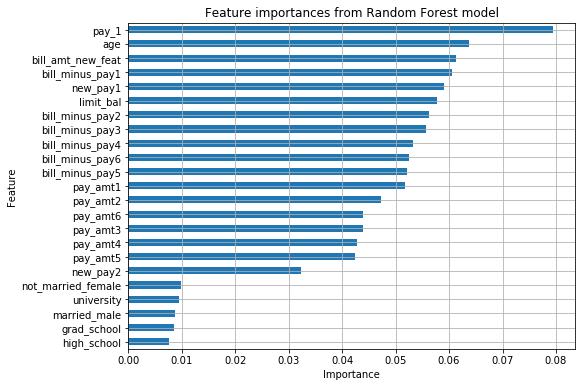

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importances = pd.Series(data=RF_classifier.best_estimator_.feature_importances_, index=feature_names)
feature_importances.sort_values().plot(kind='barh', ax=ax)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature importances from Random Forest model')
ax.grid();